In [1]:
%cd ..

/home/tianshu/prediction


In [39]:
import json

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from forecast import Dataset, Method

In [46]:
ds = Dataset("data.npz", if_data="if.npz", offset=1000. * 1000.)

with open("results/manifest.json") as f:
    methods = json.load(f)
    
results = {
    method: Method("results/{}".format(method), ds, desc)
    for method, desc in tqdm(methods.items())
}

  0%|          | 0/27 [00:00<?, ?it/s]

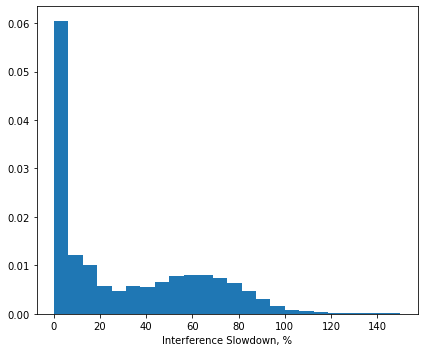

In [15]:
# Interference Histogram

def _interference_histogram():
    df = pd.read_csv("data/if.csv")
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    axs.hist(
        100 * (np.exp(df["diff"]) - 1),
        bins=np.linspace(0, 150, 25), density=True)
    axs.set_xlabel("Interference Slowdown, %")
    fig.tight_layout()
    fig.savefig("figures/interference_hist.png", dpi=300)

_interference_histogram()

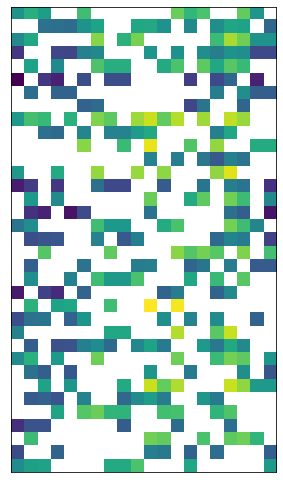

In [30]:
# Matrix Completion

def _matrix_completion():
    ds = Dataset("data/data.npz", if_data="data/if.npz", offset=1000. * 1000.)

    mat = ds.matrix[30:65]
    random_mask = np.random.rand(*mat.shape) > 0.4
    mat = np.ma.masked_where(random_mask == 1, mat)
    cmap = matplotlib.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig, axs = plt.subplots(1, 1, figsize=(mat.shape[1] / 5, mat.shape[0] / 5))
    axs.imshow(mat, cmap=cmap)
    axs.set_xticks([])
    axs.set_yticks([])
    fig.tight_layout()
    fig.savefig("figures/matrix_completion.png", dpi=300, bbox_inches='tight')

_matrix_completion()

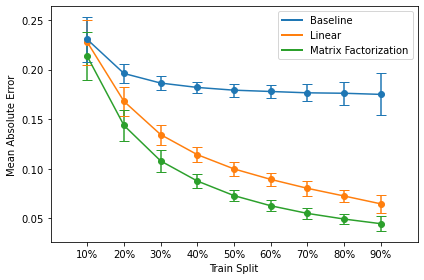

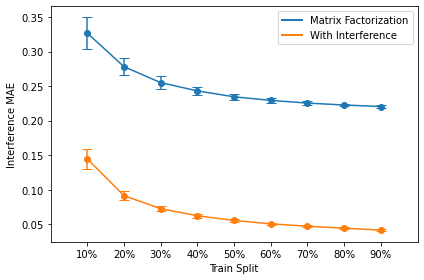

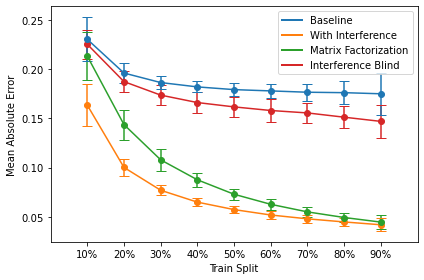

In [45]:
# Comparisons

from matplotlib.pyplot import Line2D


def plots(subset, ax=None, boxplot=True, baseline=True, key="error", labels={}):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
    colors = [
        "C{}".format(i + (1 if baseline else 0)) for i in range(len(subset))]
    legend = [labels.get(m, methods.get(m)) for m in subset]
    for color, method in zip(colors, subset):
        results[method].compare(ax, color=color, boxplot=boxplot, key=key)

    if baseline:
        colors = ["C0"] + colors
        legend = ["Baseline"] + legend
        results["Lr8"].compare(ax, color='C0', boxplot=boxplot, key="baseline")
        
    ax.legend(
        [Line2D([0], [0], color=c, lw=2) for c in colors], legend,
        loc='upper right')


def _method_comparisons():

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["Lr64", "embedding"], ax=axs, boxplot=False, baseline=True,
        key="error", labels={"Lr64": "Linear"})
    fig.tight_layout()
    fig.savefig("figures/non-interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["embedding", "interference"], ax=axs, boxplot=False,
        baseline=False, key="interference")
    axs.set_ylabel("Interference MAE")
    fig.tight_layout()
    fig.savefig("figures/interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["interference", "embedding", "ignore"], ax=axs, boxplot=False,
        baseline=True, key="error")
    fig.tight_layout()
    fig.savefig("figures/interference_error.png", dpi=300)


_method_comparisons()